# **Crime Risk in DC - Analysis**

### Packages

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

### Read in API data (2015-2019)

Below is the crime incident data for 2015-2019 from OpenDataDC (https://opendata.dc.gov/). There is a seperate API for each year, so the code below reads in the data, converts it into dataframes and concatenates them.

In [86]:
url_crime_2015 = 'https://opendata.arcgis.com/datasets/35034fcb3b36499c84c94c069ab1a966_27.geojson'
df_crime_2015 = gpd.read_file(url_crime_2015)

In [87]:
url_crime_2016 = 'https://opendata.arcgis.com/datasets/bda20763840448b58f8383bae800a843_26.geojson'
df_crime_2016 = gpd.read_file(url_crime_2016)

In [88]:
url_crime_2017 = 'https://opendata.arcgis.com/datasets/6af5cb8dc38e4bcbac8168b27ee104aa_38.geojson'
df_crime_2017 = gpd.read_file(url_crime_2017)

In [89]:
url_crime_2018 = 'https://opendata.arcgis.com/datasets/38ba41dd74354563bce28a359b59324e_0.geojson'
df_crime_2018 = gpd.read_file(url_crime_2018)

In [90]:
url_crime_2019 = 'https://opendata.arcgis.com/datasets/f08294e5286141c293e9202fcd3e8b57_1.geojson'
df_crime_2019 = gpd.read_file(url_crime_2019)

In [91]:
df_crime = pd.concat([df_crime_2015, df_crime_2016, df_crime_2017, df_crime_2018, df_crime_2019])

### Clean API Data

Remove unnecessary columns form the dataframe.

In [92]:
df_crime = df_crime[['CCN', 'START_DATE', 'END_DATE', 'REPORT_DAT', 'SHIFT', 'WARD', 'BLOCK_GROUP', 'CENSUS_TRACT', 
                     'BLOCK', 'OFFENSE', 'METHOD', 'LATITUDE', 'LONGITUDE']]

In [93]:
df_crime['year'] = pd.DatetimeIndex(df_crime['START_DATE']).year
df_crime['month'] = pd.DatetimeIndex(df_crime['START_DATE']).month
df_crime['dayofweek'] = pd.DatetimeIndex(df_crime['START_DATE']).dayofweek

df_crime['dayofweek'] = df_crime['dayofweek'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 
                                                   5:'Saturday', 6:'Sunday'})
df_crime = df_crime[pd.notnull(df_crime['START_DATE'])]

In [94]:
df_crime['date'] = df_crime['START_DATE']
df_crime.date = pd.to_datetime(df_crime.date, format='%Y/%m/%d %H:%M:%S')

df_crime.index = pd.to_datetime(df_crime.START_DATE, format='%Y/%m/%d %H:%M:%S')
df_crime.END_DATE = pd.to_datetime(df_crime.END_DATE, format='%Y/%m/%d %H:%M:%S')
df_crime.REPORT_DAT = pd.to_datetime(df_crime.REPORT_DAT, format='%Y/%m/%d %H:%M:%S')

In [95]:
# get names of indexes for columns with report dates before 2015
indexNames = df_crime[df_crime['year'] < 2015].index
# delete these row indexes from df_crime
df_crime.drop(indexNames, inplace=True)

In [96]:
hours = df_crime['date'].dt.hour
bins = [-1, 4, 9, 17, 21]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']
df_crime['time_of_day'] = np.array(labels)[np.array(bins).searchsorted(hours)-1]

In [149]:
# create new column for violent crimes and property crimes where:
#   violent = ASSAULT W/DANGEROUS WEAPON, HOMICIDE, ROBBERY, SEX ABUSE
#   property = MOTOR VEHICLE THEFT, THEFT F/AUTO, THEFT/OTHER, BURGLARY, ARSON

# define function to map values for new column
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
# create dictionary of offenses
offense_dictionary = {'ASSAULT W/DANGEROUS WEAPON': 'violent', 'HOMICIDE': 'violent', 'ROBBERY': 'violent',
                      'SEX ABUSE': 'violent', 'THEFT/OTHER': 'property', 'THEFT F/AUTO': 'property',
                      'MOTOR VEHICLE THEFT': 'property', 'BURGLARY': 'property', 'ARSON': 'property'}
# add new column to dataframe for offense grouping
df_crime['OFFENSE_GROUP'] = df_crime['OFFENSE'].apply(set_value, args=(offense_dictionary, ))

In [150]:
df_crime.head()

,CCN,START_DATE,END_DATE,REPORT_DAT,SHIFT,WARD,BLOCK_GROUP,CENSUS_TRACT,BLOCK,OFFENSE,METHOD,LATITUDE,LONGITUDE,year,month,dayofweek,date,time_of_day,OFFENSE_GROUP
START_DATE,,,,,,,,,,,,,,,,,,,
2015-08-30 02:14:49,11535619,2015-08-30T02:14:49,2015-08-30 02:20:15,2015-08-30 02:57:29,MIDNIGHT,7,007804 3,007804,4800 - 4899 BLOCK OF CENTRAL AVENUE NE,ROBBERY,GUN,38.890393,-76.933411,2015.0,8.0,Sunday,2015-08-30 02:14:49,Night,violent
2015-01-26 01:20:00,15012648,2015-01-26T01:20:00,2015-01-26 01:29:00,2015-01-26 01:29:00,MIDNIGHT,5,009102 2,009102,1000 - 1249 BLOCK OF BRENTWOOD ROAD NE,THEFT/OTHER,OTHERS,38.920149,-76.990314,2015.0,1.0,Monday,2015-01-26 01:20:00,Night,property
2015-01-26 01:35:00,15012653,2015-01-26T01:35:00,2015-01-26 01:39:00,2015-01-26 03:00:00,MIDNIGHT,1,004400 2,004400,1820 - 1899 BLOCK OF 9TH STREET NW,ROBBERY,GUN,38.915192,-77.023972,2015.0,1.0,Monday,2015-01-26 01:35:00,Night,violent
2015-01-26 01:30:00,15012660,2015-01-26T01:30:00,2015-01-26 02:00:00,2015-01-26 03:29:00,MIDNIGHT,5,008903 2,008903,2100 - 2199 BLOCK OF M STREET NE,THEFT/OTHER,OTHERS,38.905616,-76.973691,2015.0,1.0,Monday,2015-01-26 01:30:00,Night,property
2015-01-26 03:45:00,15012670,2015-01-26T03:45:00,2015-01-26 04:00:00,2015-01-26 04:00:00,MIDNIGHT,2,010100 2,010100,1500 - 1549 BLOCK OF MASSACHUSETTS AVENUE NW,ROBBERY,OTHERS,38.906703,-77.035003,2015.0,1.0,Monday,2015-01-26 03:45:00,Night,violent


### Quick EDA

In [215]:
crime_year = pd.DataFrame(df_crime.year.value_counts())
crime_year = pd.DataFrame(crime_year.iloc[:,0])
crime_year.columns = ['Total Crime per Year']
crime_year

,Total Crime per Year
2015.0,37337
2016.0,37175
2018.0,33787
2017.0,33037
2019.0,29146


In [214]:
crime_week = pd.DataFrame(df_crime.dayofweek.value_counts())
crime_week.columns = ['Total Crime per Day of Week']
crime_week

,Total Crime per Day of Week
Friday,26430
Saturday,24968
Monday,24432
Wednesday,23930
Tuesday,23783
Thursday,23691
Sunday,23248


In [216]:
# type of weapon used in attack

method_df = pd.DataFrame(df_crime.METHOD.value_counts())
method_df.columns = ['Total Crime by Weapon Used']
method_df

,Total Crime by Weapon Used
OTHERS,157215
GUN,8899
KNIFE,4368


### Visualizations

The below visualizations are for the purposes of exploratory data analysis.

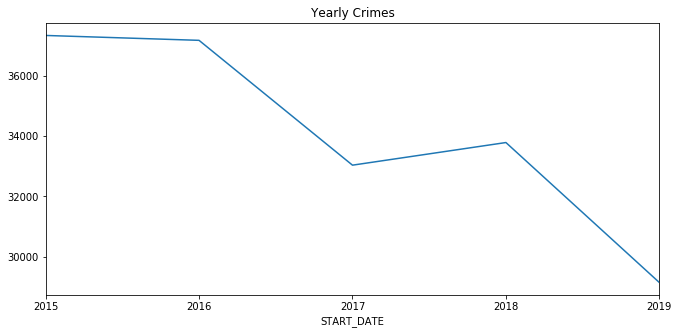

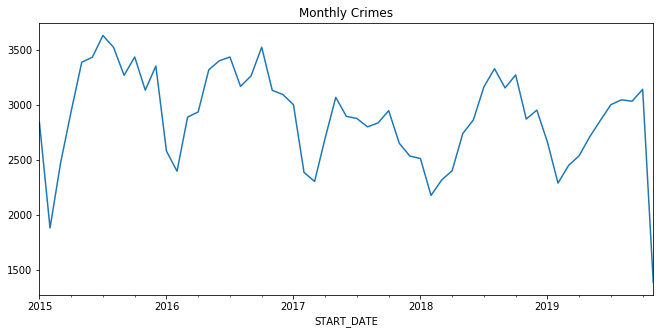

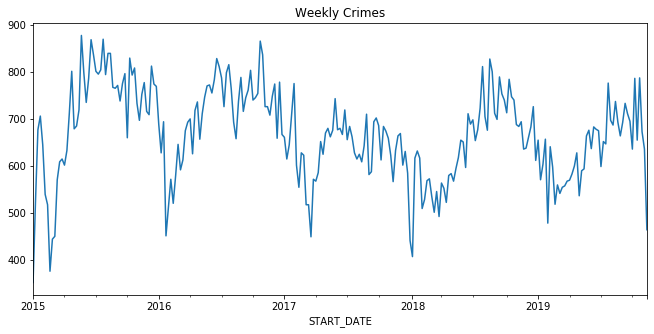

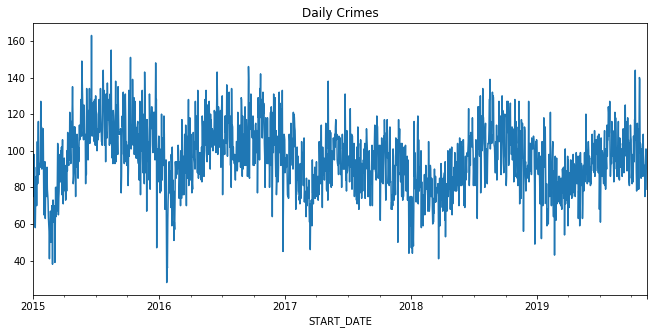

In [148]:
# number of crimes per year
plt.figure(figsize=(11, 5))
df_crime.resample('Y').size().plot()
plt.title('Yearly Crimes')
plt.show()

# number of crimes per month
plt.figure(figsize=(11, 5))
df_crime.resample('m').size().plot()
plt.title('Monthly Crimes')
plt.show()

# number of crimes per week
plt.figure(figsize=(11, 5))
df_crime.resample('W').size().plot()
plt.title('Weekly Crimes')
plt.show()

# number of crimes per day
plt.figure(figsize=(11, 5))
df_crime.resample('d').size().plot()
plt.title('Daily Crimes')
plt.show()

In [154]:
df_crime_2015 = df_crime[df_crime['year'] == 2015]
df_crime_2016 = df_crime[df_crime['year'] == 2016]
df_crime_2017 = df_crime[df_crime['year'] == 2017]
df_crime_2018 = df_crime[df_crime['year'] == 2018]
df_crime_2019 = df_crime[df_crime['year'] == 2019]

group_type = df_crime.groupby(['year', 'OFFENSE_GROUP'])['date'].count().unstack()
group_all = df_crime.groupby(['year', 'OFFENSE'])['date'].count().unstack()
group_2015 = df_crime_2015.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2016 = df_crime_2016.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2017 = df_crime_2017.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2018 = df_crime_2018.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2019 = df_crime_2019.groupby(['month', 'OFFENSE'])['date'].count().unstack()

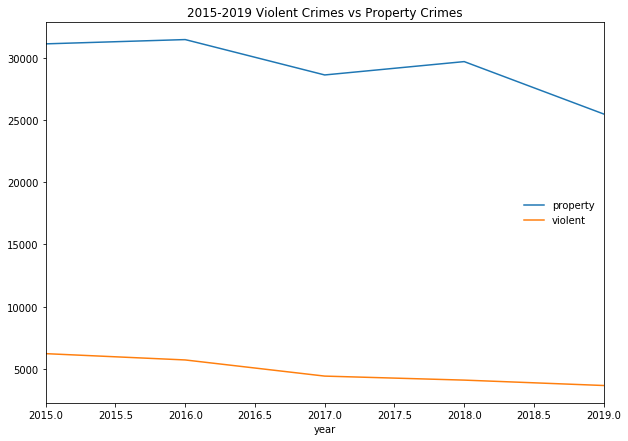

In [156]:
plt.rcParams['figure.figsize'] = [10, 7]

group_type.plot()
plt.title('2015-2019 Violent Crimes vs Property Crimes')
plt.legend(loc='right', frameon=False)
plt.show()

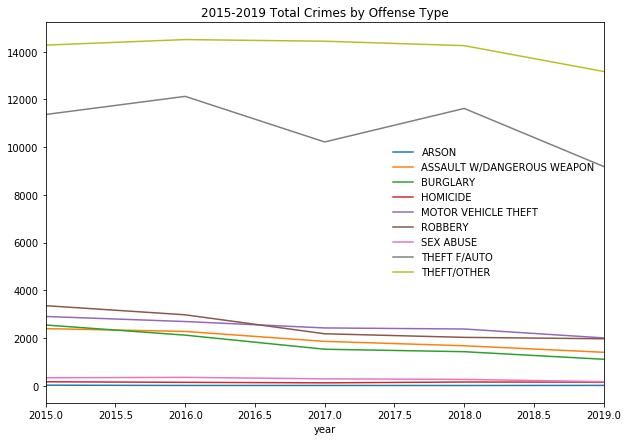

In [157]:
group_all.plot()
plt.title('2015-2019 Total Crimes by Offense Type')
plt.legend(loc='right', frameon=False)
plt.show()

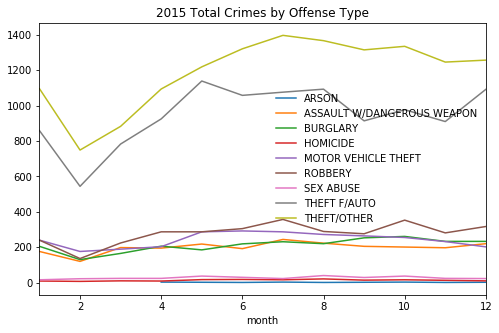

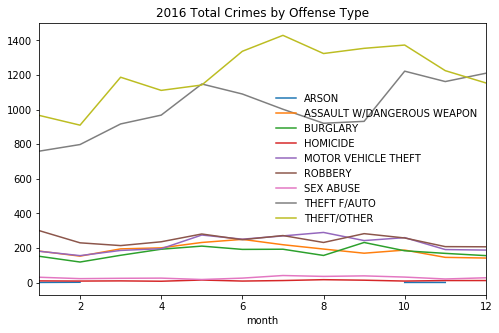

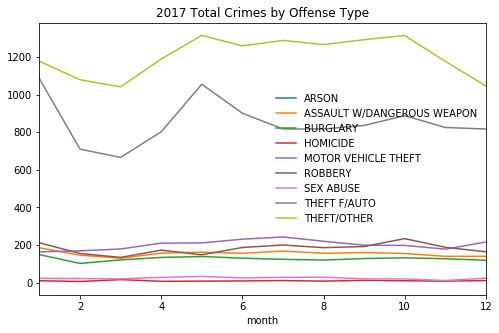

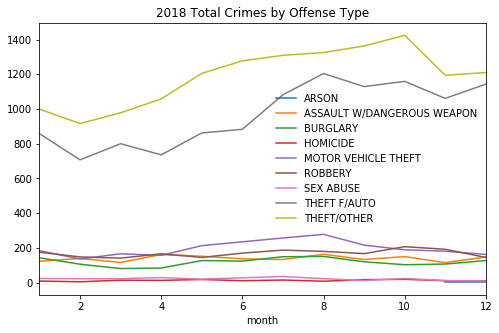

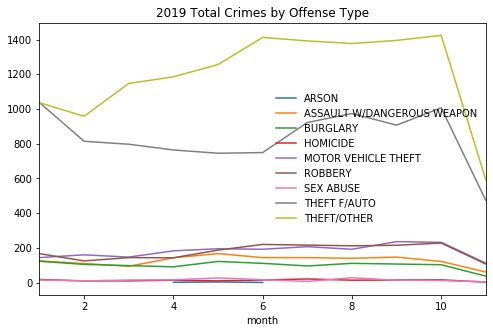

In [159]:
plt.rcParams['figure.figsize'] = [8, 5]

group_2015.plot()
plt.title('2015 Total Crimes by Offense Type')
plt.legend(loc='right', frameon=False)
plt.show()

group_2016.plot()
plt.title('2016 Total Crimes by Offense Type')
plt.legend(loc='right', frameon=False)
plt.show()

group_2017.plot()
plt.title('2017 Total Crimes by Offense Type')
plt.legend(loc='right', frameon=False)
plt.show()

group_2018.plot()
plt.title('2018 Total Crimes by Offense Type')
plt.legend(loc='right', frameon=False)
plt.show()

group_2019.plot()
plt.title('2019 Total Crimes by Offense Type')
plt.legend(loc='right', frameon=False)
plt.show()

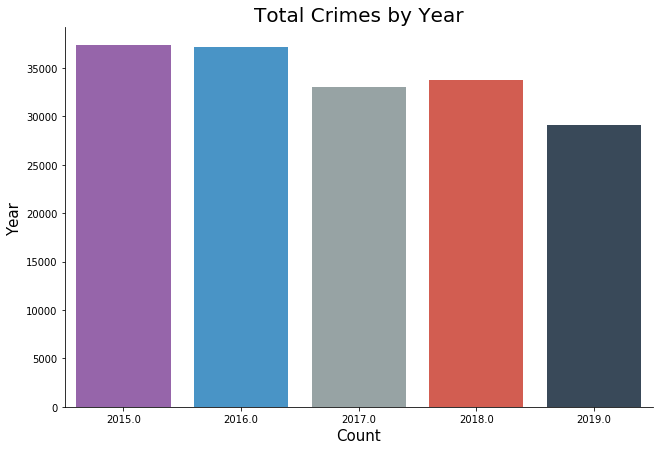

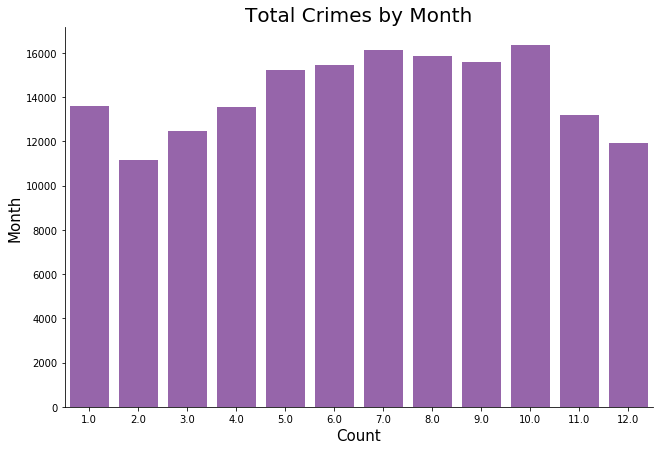

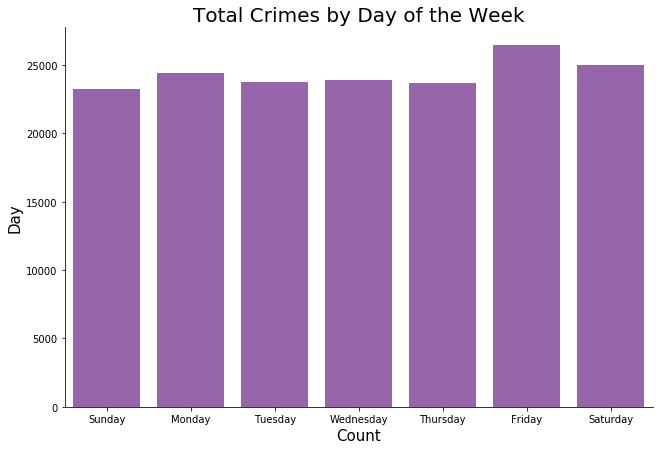

In [200]:
color = ['#9b59b6']

# categorical plot for total crimes by year
plot = sns.catplot(x='year', kind='count', height=6, aspect=1.5, 
                   data=df_crime, palette=sns.color_palette(flatui))
plt.title('Total Crimes by Year', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Year', fontsize=15)
plt.show()

# categorical plot for total crimes by month
sns.catplot(x='month', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color))
plt.title('Total Crimes by Month', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Month', fontsize=15)
plt.show()

# categorical plot for total crimes by day of the week
sns.catplot(x='dayofweek', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color), 
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Total Crimes by Day of the Week', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Day', fontsize=15)
plt.show()

Text(-150.559375, 0.5, 'Offense Type')

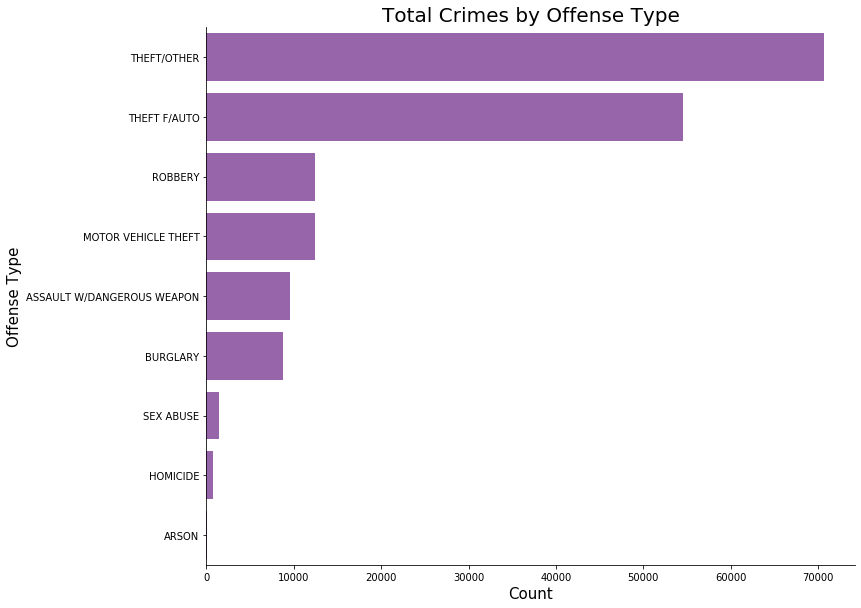

In [201]:
# categorical plot for count of offense type

sns.catplot(y='OFFENSE', kind='count', height=8, aspect=1.5, order=df_crime.OFFENSE.value_counts().index, 
            data=df_crime, palette=sns.color_palette(color))

plt.title('Total Crimes by Offense Type', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Offense Type', fontsize=15)

  Weapon Used   Count
0      OTHERS  157215
1         GUN    8899
2       KNIFE    4368


<function matplotlib.pyplot.show(*args, **kw)>

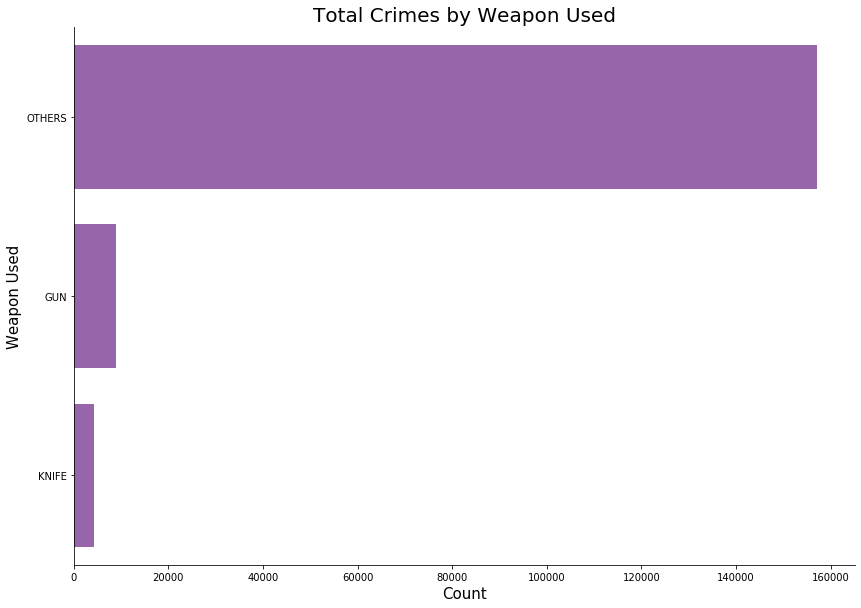

In [211]:
# type of weapon used in attack

sns.catplot(y='METHOD', kind='count', height=8, aspect=1.5, order=df_crime.METHOD.value_counts().index, 
            data=df_crime, palette=sns.color_palette(color))
plt.title('Total Crimes by Weapon Used', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Weapon Used', fontsize=15)
plt.show

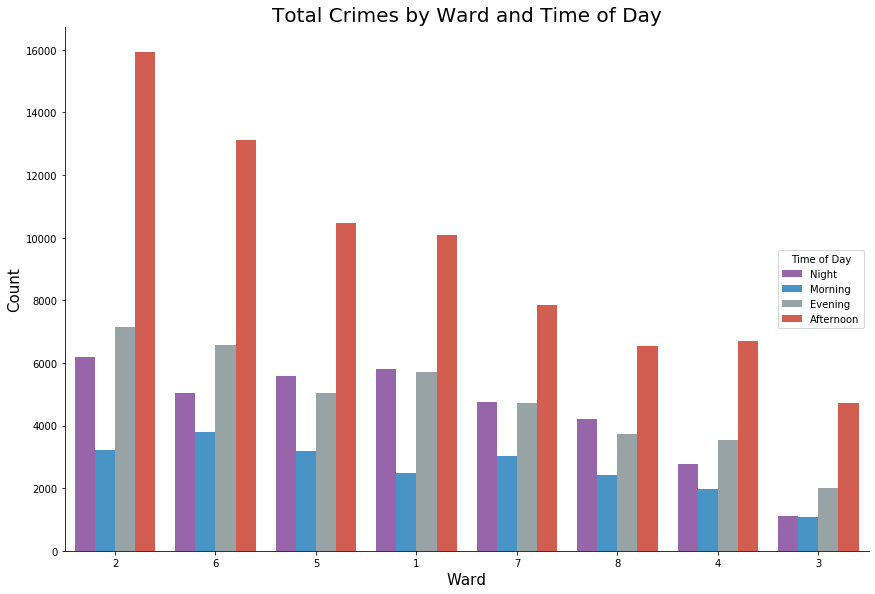

In [207]:
# categorical plot for count of total crimes by ward and time of day

flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']

sns.catplot(x='WARD', hue='time_of_day', kind='count', height=8, aspect=1.5, order=df_crime.WARD.value_counts().index, 
            data=df_crime, legend=False, palette=sns.color_palette(flatui))

plt.title('Total Crimes by Ward and Time of Day', fontsize=20)

plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Ward', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(title='Time of Day', loc='right')